# Supervised Classification using TabNet

In this notebook, we will see how to use the TabNet layers from this repository to build a supervised learning classifier in TF Keras. As an example, we will analyze the [Adult Census Income dataset](https://archive.ics.uci.edu/ml/datasets/adult). The goal here is to predict the income bracket (earns <=\$50K or >50K) of an individual based on some descriptive features (e.g., age, sex, race, marital status, occupation, capital gain/loss, etc.).

In [1]:
import sys 
sys.path.append("../")

import torch
import pandas as pd
import plotly.express as px
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from utils.load_data import get_datasets_np
from pytorch_tabnet.tab_model import TabNetClassifier

## Loading and preparing data
We load the Adult Census Income dataset from the UCI data repository. We impute the missing values with the mode value. We encode the labels into binary. Finally, we convert the data into [TF Dataset format](https://www.tensorflow.org/api_docs/python/tf/data/Dataset).

In [2]:
x,y, class_weights = get_datasets_np()


#'time', 'age', 'gender_f', 'gender_m'
time = ['time']
vital = ['rr','hr','spo2','sbp','dbp','temp']
CBC = ['hct','hb','platelets','wbc','rbc','mch','mchc','mcv']
ABGA = ['ph','hco3', 'po2','pco2','sao2','fio2','pfratio']
time_series = time+vital+CBC+ABGA
info = ['age', 'gender_f', 'gender_m']
scores = ['Rox', 'MEWS', 'NEWS', 'Sofa', 'QSofa']
name = time_series+info+scores

def flatten_name(name, N):
    return [name[i] + '_' + str(j) for i in range(len(name)) for j in range(1, N+1)]

def flatten_ts(X):
    X_ts  =X[:,:,:-8]
    X_static = X[:,0,-8:-6] #exclude gender_m
    X_score = X[:,:,-5:]
    flat_x_ts = np.transpose(X_ts, (0, 2, 1)).reshape(X_ts.shape[0], -1)
    datasets_score = np.transpose(X_score, (0, 2, 1)).reshape(X_score.shape[0], -1)
    flatten_x = np.concatenate((flat_x_ts, X_static, datasets_score), axis=1)
    return flatten_x    

flat_names = flatten_name(time_series,6) + ['age', 'gender'] + flatten_name(scores,6)

flat_x = []
df = []
for i in range(4):
    flat_x.append(flatten_ts(x[i]))
    df.append(pd.DataFrame(flat_x[i], columns=flat_names))

dataset_names = ['train','valid','test_icu','test_covid']

# datasets = []
# for i in range(4):
#     tfdata = tf.data.Dataset.from_tensor_slices((flat_x[i],y[i]))
#     # tfdata = tf.data.Dataset.from_tensor_slices(datasets[i],y[i])
#     tfdata = tfdata.batch(1024).prefetch(tf.data.experimental.AUTOTUNE)
#     datasets.append(tfdata)

(995318, 6, 30)
(254005, 6, 30)
(114869, 6, 30)
(13710, 6, 30)


In [3]:
def plot_history(model):
    hist = model.history
    for label, values in hist.history.items():
        if label.endswith('_auc'):
            plt.plot(values, label=label)

    plt.axhline(y=0.819, color='r', linestyle='--')
    plt.axhline(y=0.792, color='orange', linestyle='--')
    plt.axhline(y=0.835, color='g', linestyle='--')
    plt.legend(loc='lower right')  # Display the legend (labels)
    plt.show()  # Display the plot

In [5]:
# do plane tabnet training
# here we use default value

from pytorch_tabnet.tab_model import TabNetClassifier

classifier = TabNetClassifier(
    n_d=8, # 8~64
    n_a=8, #  ==n_d
    n_steps=3, # 3~10
    n_independent=2, # 1~5
    n_shared = 2, #1~5
    optimizer_fn=torch.optim.Adam, # default
    optimizer_params=dict(lr=1e-2),
    scheduler_fn = None,
    lambda_sparse = 1e-3,
    device_name = 'auto',
    mask_type='sparsemax'# "sparsemax", entmax
    #model_name
    )

classifier.fit(X_train=flat_x[0], y_train=y[0],
               eval_set=[(flat_x[0], y[0]), (flat_x[2], y[2]), (flat_x[3], y[3]), (flat_x[1], y[1])],
               eval_name=['train', 'test_icu', 'test_covid', 'valid'],
               eval_metric=['auc'],
               max_epochs=50,
               patience=10,
               weights=0, # 0 no sample / 1 --> sampling considering class weight
               # loss = CE
               batch_size=1024,
               virtual_batch_size=128,
               num_workers = 8, # number of workers used in torch dataloader
               drop_last= False,
               callbacks=None,
               #pretraining_ratio  for pretrainer only
               )
plot_history(classifier)

/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.16667 | train_auc: 0.76083 | test_icu_auc: 0.68754 | test_covid_auc: 0.80347 | valid_auc: 0.76045 |  0:00:49s
epoch 1  | loss: 0.14986 | train_auc: 0.76783 | test_icu_auc: 0.68598 | test_covid_auc: 0.73723 | valid_auc: 0.76438 |  0:01:37s
epoch 2  | loss: 0.14728 | train_auc: 0.78156 | test_icu_auc: 0.71073 | test_covid_auc: 0.82782 | valid_auc: 0.77565 |  0:02:25s
epoch 3  | loss: 0.14523 | train_auc: 0.79038 | test_icu_auc: 0.7155  | test_covid_auc: 0.78204 | valid_auc: 0.78092 |  0:03:14s
epoch 4  | loss: 0.14296 | train_auc: 0.80248 | test_icu_auc: 0.71279 | test_covid_auc: 0.7658  | valid_auc: 0.8018  |  0:04:03s


KeyboardInterrupt: 

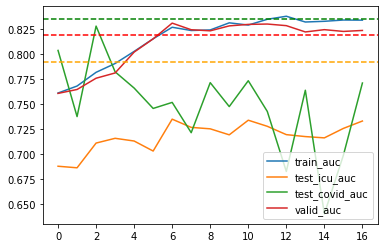

In [ ]:
plot_history(classifier)

In [ ]:
# change weight

classifier2 = TabNetClassifier(
    n_d=8, # 8~64
    n_a=8, #  ==n_d
    n_steps=3, # 3~10
    n_independent=2, # 1~5
    n_shared = 2, #1~5
    optimizer_fn=torch.optim.Adam, # default
    optimizer_params=dict(lr=1e-2),
    scheduler_fn = None,
    mask_type='sparsemax'# "sparsemax", entmax
    #model_name
    )

classifier2.fit(X_train=flat_x[0], y_train=y[0],
               eval_set=[(flat_x[0], y[0]), (flat_x[2], y[2]), (flat_x[3], y[3]), (flat_x[1], y[1])],
               eval_name=['train', 'test_icu', 'test_covid', 'valid'],
               eval_metric=['auc'],
               max_epochs=50,
               patience=10,
               weights=1, # 0 no sample / 1 --> sampling considering class weight
               # loss = CE
               batch_size=1024,
               virtual_batch_size=128,
               num_workers = 8, # number of workers used in torch dataloader
               drop_last= False,
               callbacks=None,
               #pretraining_ratio  for pretrainer only
               )
plot_history(classifier2)

/home/minkoo/.conda/envs/tf/lib/python3.9/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.56299 | train_auc: 0.8055  | test_icu_auc: 0.72492 | test_covid_auc: 0.79415 | valid_auc: 0.79996 |  0:00:49s


KeyboardInterrupt: 

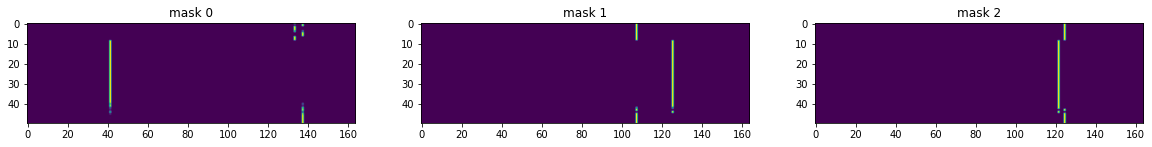

In [ ]:

explain_matrix, masks = classifier.explain(flat_x[1])

fig, axs = plt.subplots(1, 3, figsize=(20,20))
for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

Hyperparameter search using optuna

In [ ]:
import optuna
from optuna import Trial, visualization

    # def __init__(
    #     self,
    #     num_features,
    #     feature_dim,
    #     output_dim,
    #     n_step = 2,
    #     n_total = 4,
    #     n_shared = 2,
    #     relaxation_factor = 1.5,
    #     bn_epsilon = 1e-5,
    #     bn_momentum = 0.7,
    #     sparsity_coefficient = 1e-5
    # ):
# classifier2 = TabNetClassifier(
#     n_d=8, # 8~64    == feature_dim
#     n_a=8, #  ==n_d   == num_features
#     gamma=1.3
#     n_steps=3, # 3~10
#     n_independent=2, # 1~5
#     n_shared = 2, #1~5
#     optimizer_fn=torch.optim.Adam, # default
#     optimizer_params=dict(lr=1e-2),
#     scheduler_fn = None,
#     lambda_sparse = 1e-3,
#     momentum = 0.02,
#     mask_type='sparsemax'# "sparsemax", entmax
#     #model_name
#     )

def Objective(trial):
    feature_dim = trial.suggest_categorical("n_d", [8,16,32, 64, 128])
    n_step = trial.suggest_int("n_step", 2, 9, step=1)
    n_shared = trial.suggest_int("n_shared", 0, 4, step=1)
    relaxation_factor = trial.suggest_float("gamma", 1., 3., step=0.1)
    sparsity_coefficient = trial.suggest_float("lambda_sparse", 0.00000001, 0.1, log=True)
    bn_momentum = trial.suggest_float('momentum', 0.9, 0.9999)
    tabnet_params = dict(num_features=flat_x[0].shape[1],
                         output_dim=feature_dim,
                         feature_dim=feature_dim,
                         n_step=n_step, 
                         relaxation_factor=relaxation_factor,
                         sparsity_coefficient=sparsity_coefficient,
                         n_shared = n_shared,
                         bn_momentum = bn_momentum
                     )
    class_weight =  trial.suggest_int("class_weight", 1, 10.5, step=0.5)
    
    cbs = [tf.keras.callbacks.EarlyStopping(
            monitor="val_loss", patience=5, restore_best_weights=True
        )]
    
    tn = TabNetClassifier(**tabnet_params)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,clipnorm=10)
    loss = [tf.keras.losses.CategoricalCrossentropy(from_logits=False),None]
    
    tn.compile(
            optimizer,
            loss=loss)

    tn.fit(train_ds, 
          epochs=100, 
          validation_data=val_ds,
          callbacks=cbs,
          verbose=1)
    
    
    val_preds, _ =  tn.predict(val_ds)
    pr_auc = average_precision_score(val_y, val_preds[:,1])
    
    return pr_auc

study = optuna.create_study(direction="maximize", study_name='TabNet optimization')
study.optimize(Objective, n_jobs=1, n_trials=100, gc_after_trial=True, show_progress_bar=True) 

IndentationError: unexpected indent (1084955490.py, line 4)